In [133]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [244]:
import pandas as pd
def binbinplot(y1, y2, bins = 100, 
               ax = None, title = None,
               xlabel=None, ylabel=None):
    df = pd.DataFrame({'y1': y1, 'y2': y2})
    df['bin'] = pd.qcut(df['y1'], bins)
    bin_y1 = df.groupby('bin', observed=True)['y1'].mean()
    bin_y2 = df.groupby('bin', observed=True)['y2'].mean()

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)


    ax.scatter(bin_y1, bin_y2, alpha = 0.8)

In [245]:
def generate_data(n_samples, target_cm, random_state, vis_cm = False):
    rng = np.random.default_rng(random_state)
    n_features, _ = target_cm.shape

    # use the cholesky decomposition to get target_cm = L @ L.T
    L = np.linalg.cholesky(target_cm)


    # generate the data using L to produce the desired correlations
    Z = rng.normal(size=(n_samples, n_features))
    data = Z @ L.T

    empirical_cm = np.corrcoef(data, rowvar=False)
    if vis_cm:
        sns.heatmap(empirical_cm, annot=True)

    print(f"data std dev:", data.std(axis = 0))

    return data

In [246]:
def generate_cm(feature_feature_corr, feature_target_corr):
    R = np.full((11, 11), feature_feature_corr)
    np.fill_diagonal(R, 1.0)
    R[-1, :-1] = feature_target_corr
    R[:-1, -1] = feature_target_corr

    return R

In [247]:
def run_fit(data):
    features = data[:, :10]
    target = data[:, 10]

    num_train = int(0.8 * len(features))
    train_X, train_y = features[:num_train], target[:num_train]
    test_X, test_y = features[num_train:], target[num_train:]

    model = LinearRegression(fit_intercept = False)
    model.fit(train_X, train_y)
    print(f"model.coef_ = {model.coef_}")



    fig, axs = plt.subplots(1,1, figsize=(8,6))
    axs.grid()

    train_y_pred = model.predict(train_X)
    train_R2 = model.score(train_X, train_y)

    test_y_pred = model.predict(test_X)
    test_R2 = model.score(test_X, test_y)

    axs.set_title(f'Train R2: {train_R2:.4f}, Test R2: {test_R2:.4f}')
    binbinplot(train_y_pred, 
               train_y,
               ax = axs,
               bins = 20,
               xlabel = 'y_pred', ylabel = 'y_true')
    binbinplot(test_y_pred, 
               test_y,
               ax = axs,
               bins = 20,
               xlabel = 'y_pred', ylabel = 'y_true')
    
    axs.legend(['train', 'test'])

data std dev: [0.97294611 0.95706464 1.00621503 1.04501148 0.87127693 1.04916806
 1.08466905 0.9772648  0.86345867 1.10525094 0.92265732]
model.coef_ = [ 0.40749812 -0.46511603  0.25284343  0.09919746 -0.02735455  0.03500229
  0.04416704  0.14281271  0.25822015  0.13816965]


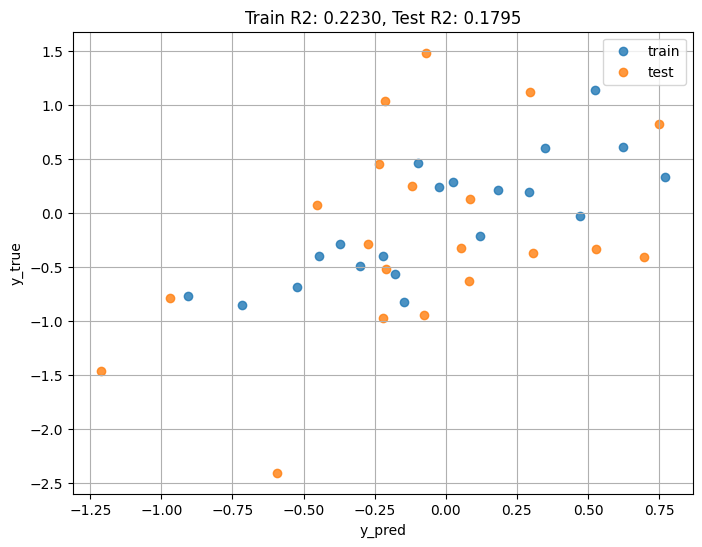

In [251]:
R = generate_cm(0.05, 0.1)
modify = [(0, 10, 0.01), (1, 10, 0.01), (0, 1, 0.9)]
for i, j, corr in modify:
    R[i, j] = R[j, i] = corr

# data = generate_data(100, R, 0, vis_cm=True)
data = generate_data(100, R, 0)

run_fit(data)

data std dev: [0.97294611 0.92001084 1.0077727  1.04581739 0.87274427 1.04742683
 1.09079978 0.97570129 0.86699314 1.10366331 0.91099224]
model.coef_ = [ 0.08813453 -0.14095355  0.24652441  0.09341055 -0.03245943  0.02969358
  0.03884995  0.13696465  0.25162249  0.13200789]


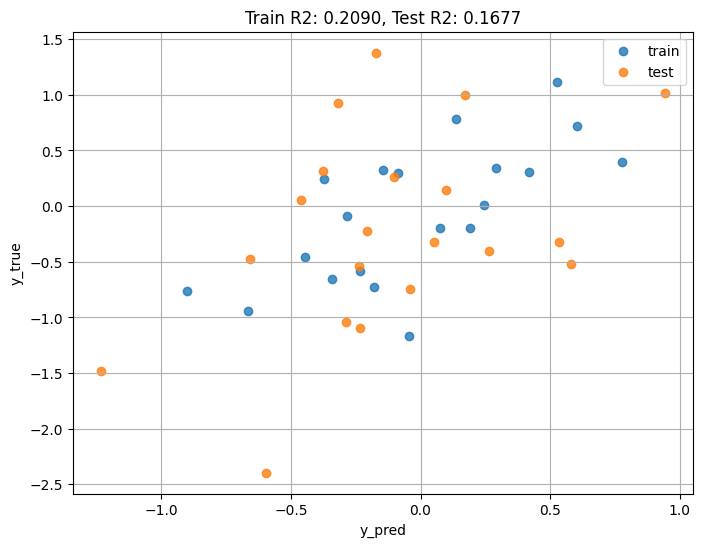

In [249]:
R = generate_cm(0.05, 0.1)
modify = []
for i, j, corr in modify:
    R[i, j] = R[j, i] = corr

data = generate_data(100, R, 0, vis_cm = False)
run_fit(data)